# Set up

In [1]:
# update path with data dir
import sys
sys.path.append('../../optimiser/')

In [116]:
import pandas as pd
import patsy
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import PredefinedSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import optimiser

In [3]:
import warnings
# warnings.filterwarnings('ignore')

# Getting data

In [4]:
file_name = '../csvs/element_gameweek_features_v04.csv'

In [5]:
element_gameweek_df = pd.read_csv(file_name)

In [6]:
element_gameweek_df.fillna(3, inplace=True)

In [7]:
element_gameweek_df = element_gameweek_df[element_gameweek_df['rolling_avg_minutes_element_p3'] >= 60]

# Evaluating models

## Helpers

In [8]:
formula = \
'total_points ~ C(element) + C(element_type) + C(team) + C(opposition_team) + ' + \
' + '.join([i for i in element_gameweek_df.columns if i not in
 [
     'safe_web_name',
     'element',
     'event',
     'fixture',
     'team',
     'opposition_team',
     'element_type',
     'rolling_avg_attempted_passes_element',
     'rolling_var_total_points_against_opposition_team',
     'rolling_var_total_points_own_team',
     'rolling_var_total_points_opposition_team',
     'rolling_var_total_points_element_type',
     'rolling_var_total_points_against_opposition_team_element_type',
     'expected_var_total_points_against_opposition_team',
     'expected_var_total_points_at_ground',
     'rolling_avg_total_points_home',
     'rolling_var_total_points_home',
     'rolling_avg_total_points_against_opposition_ground_element_type',
     'rolling_var_total_points_against_opposition_ground_element_type',
     'total_points'
 ]])

In [9]:
scaled_feature_cols = [
    i for i in element_gameweek_df.columns if i not in [
        'safe_web_name', 'element', 'event', 'fixture', 'team',
        'opposition_team', 'element_type', 'was_home', 'is_sunday',
        'is_weekday', 'is_late', 'is_early', 'total_points'
    ]
]

#scaled_feature_cols

In [74]:
def predict_test_set(df, model, features=False, standardise=True, start=21, end=38, verbose=0):
    y_pred_arr = []
    y_test_arr = []
    event_df_test_arr = []

    # for each event we want to predict
    for e in range(start, end + 1):
        if verbose > 0:
            print('predicting event', e)
        # filter weeks after test week
        event_df = df.copy()
        event_df = event_df[event_df['event'] <= e]
        
        # define train-test split
        test_fold = [-1 if i <= e - 1 else 0 for i in event_df['event']]
        ps = PredefinedSplit(test_fold)

        # split df into train and test
        for train_index, test_index in ps.split():
            event_df_train, event_df_test = \
            event_df.copy().iloc[train_index], event_df.copy().iloc[test_index]
        
        # standardise appropriate variables if necessary
        scaled_event_df = event_df.copy()
        if standardise:
            scale_train = event_df_train.copy()
            scale_test = event_df_test.copy()
            scale_df = event_df.copy()
            scaled_event_df_train = event_df_train.copy()
            scaled_event_df_test = event_df_test.copy()

            scaler = StandardScaler().fit(scale_train[scaled_feature_cols].values)

            scale_train = scaler.transform(scale_train[scaled_feature_cols].values)
            scale_test = scaler.transform(scale_test[scaled_feature_cols].values)
            scale_df = scaler.transform(scale_df[scaled_feature_cols].values)

            scaled_event_df_train[scaled_feature_cols] = scale_train
            scaled_event_df_test[scaled_feature_cols] = scale_test
            scaled_event_df[scaled_feature_cols] = scale_df         

        # get reponse vector and feature matrix
        event_y, event_X = patsy.dmatrices(formula, scaled_event_df, return_type='matrix')
        
        # split response vector and feature matrix into train and test
        for train_index, test_index in ps.split():
            event_X_train, event_X_test = event_X[train_index], event_X[test_index]
            event_y_train, event_y_test = event_y[train_index], event_y[test_index]
        
        # get size of total feature set
        n_all_features = event_X.shape[1]
        
        # if only certain features selected, get their indices
        if features:
            features_index = np.zeros(n_all_features, dtype=bool)

            for i in range(0, n_all_features):
                j = event_X.design_info.column_names[i]
                if j in features:
                    features_index[i] = True
        # otherwise take all features
        else:
            features_index = np.ones(n_all_features, dtype=bool)
        
        # throw away features that are not selected
        event_X_train_sel = event_X_train[:,features_index]
        event_X_test_sel = event_X_test[:,features_index]

        # fit model on training data
        model.fit(event_X_train_sel, event_y_train.ravel())
        # predict test event
        event_y_pred = model.predict(event_X_test_sel).flatten()
        
        # collect predictions and observations 
        y_pred_arr.append(event_y_pred)
        y_test_arr.append(event_y_test)
        
        event_df_test['predicted_total_points'] = event_y_pred
        event_df_test_arr.append(event_df_test)
        
    
    return np.concatenate(y_pred_arr).ravel(), np.concatenate(y_test_arr).ravel(), pd.concat(event_df_test_arr)

In [11]:
def construct_event_teams_from_scratch(df, optimise_key='predicted_total_points', start=21, end=38, verbose=0):
    first_team_arr = []
    bench_arr = []
    team_total_points_arr = []
    predicted_team_total_points_arr = []
    team_df_arr = []

    for e in range(start, end + 1):
        if verbose > 0:
            print('predicting event', e)
        
        event_players = df.copy()
        event_players = event_players[event_players['event'] == e]

        event_players_group = event_players.groupby('element')[optimise_key].sum()
        event_players = event_players[['element', 'value', 'element_type', 'team']].drop_duplicates()

        event_players = event_players.join(event_players_group, on='element')
        
        event_players = event_players.to_dict('records')

        try:
            event_first_team, event_bench = \
            optimiser.construct_optimal_team_from_scratch(event_players, optimise_key=optimise_key)

            first_team_arr.append(event_first_team)
            bench_arr.append(event_bench)
        except Exception as ex:
            print(e, ex)
            first_team_arr.append([])
            bench_arr.append([])
    
        event_team_total_points, event_team_predicted_total_points, event_team_df = \
        optimiser.calculate_team_total_points(df[df['event'] == e], event_first_team, event_bench)

        team_total_points_arr.append(event_team_total_points)
        predicted_team_total_points_arr.append(event_team_predicted_total_points)
        team_df_arr.append(event_team_df)
    
    return first_team_arr, bench_arr, team_total_points_arr, predicted_team_total_points_arr, team_df_arr

## Predicting points

### Linear regression

In [12]:
lr_model = LinearRegression()

In [13]:
lr_features = [
    'C(element)[T.183]',
    'C(element)[T.189]',
    'C(element)[T.511]',
    'C(element)[T.512]'
]

In [14]:
lr_y_pred, lr_y_test, lr_df_test = predict_test_set(
    element_gameweek_df,
    lr_model,
    features=lr_features,
    standardise=True
)

In [15]:
lr_test_loss = (
    mean_absolute_error(lr_y_test, lr_y_pred),
    mean_squared_error(lr_y_test, lr_y_pred),
    r2_score(lr_y_test, lr_y_pred)
)
lr_test_loss

(2.3891621767560127, 10.275134773295774, -0.00025733139878769684)

In [16]:
lr_df_test.head()

,safe_web_name,element,event,fixture,team,opposition_team,was_home,element_type,value,is_sunday,...,rolling_var_total_points_home,rolling_avg_total_points_against_opposition_ground_element_type,rolling_var_total_points_against_opposition_ground_element_type,total_points,minutes,expected_avg_total_points_against_opposition_team,expected_var_total_points_against_opposition_team,expected_avg_total_points_at_ground,expected_var_total_points_at_ground,predicted_total_points
58,leno,2,21,201,1,9,1,1,48,0,...,3.476190,3.000000,3.000000,3,90,2.478082,3.264527,3.142857,3.476190,2.87741
286,kolasinac,8,21,201,1,9,1,2,49,0,...,9.200000,3.000000,3.000000,7,90,2.415031,11.280897,3.800000,9.200000,2.87741
324,chambers,9,21,201,9,1,0,2,42,0,...,2.982143,1.666667,7.546099,0,0,0.691897,2.296830,0.675738,2.686572,2.87741
400,lichtsteiner,11,21,201,1,9,1,2,45,0,...,0.666667,3.000000,3.000000,0,0,0.603758,0.549070,1.000000,0.666667,2.87741
438,sokratis,12,21,201,1,9,1,2,51,0,...,5.100000,3.000000,3.000000,5,90,1.207515,2.445858,1.500000,5.100000,2.87741


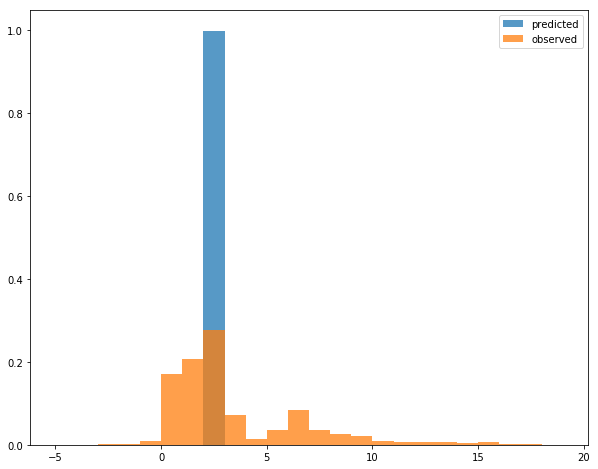

In [17]:
plt.figure(figsize=(10, 8))
plt.hist(pd.Series(lr_y_pred), bins=range(-5,20), alpha=0.75, density=True, label='predicted')
plt.hist(pd.Series(lr_y_test), bins=range(-5,20), alpha=0.75, density=True, label='observed')
plt.legend()
plt.show()

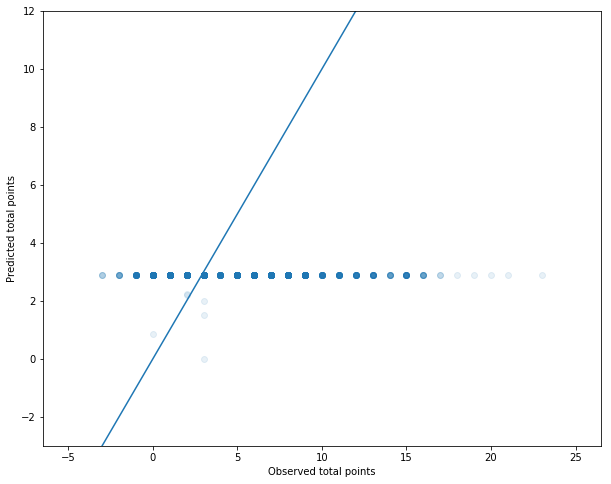

In [18]:
plt.figure(figsize=(10, 8))
plt.scatter(pd.Series(lr_y_test), pd.Series(lr_y_pred), alpha=0.1)
plt.plot(np.linspace(-5, 25), np.linspace(-5, 25))
plt.ylabel('Predicted total points')
plt.xlabel('Observed total points')
plt.ylim((-3, 12))
plt.show()

### Ridge regression (lush)

In [19]:
lush_ridge_model = Ridge(alpha=270)

In [20]:
lush_ridge_features = [
    'C(element)[T.4]', 'C(element)[T.6]', 'C(element)[T.12]',
    'C(element)[T.14]', 'C(element)[T.18]', 'C(element)[T.22]',
    'C(element)[T.23]', 'C(element)[T.24]', 'C(element)[T.27]',
    'C(element)[T.28]', 'C(element)[T.33]', 'C(element)[T.37]',
    'C(element)[T.39]', 'C(element)[T.40]', 'C(element)[T.43]',
    'C(element)[T.48]', 'C(element)[T.49]', 'C(element)[T.50]',
    'C(element)[T.54]', 'C(element)[T.56]', 'C(element)[T.58]',
    'C(element)[T.60]', 'C(element)[T.61]', 'C(element)[T.62]',
    'C(element)[T.69]', 'C(element)[T.71]', 'C(element)[T.73]',
    'C(element)[T.75]', 'C(element)[T.76]', 'C(element)[T.77]',
    'C(element)[T.79]', 'C(element)[T.80]', 'C(element)[T.82]',
    'C(element)[T.84]', 'C(element)[T.85]', 'C(element)[T.88]',
    'C(element)[T.90]', 'C(element)[T.91]', 'C(element)[T.94]',
    'C(element)[T.95]', 'C(element)[T.98]', 'C(element)[T.99]',
    'C(element)[T.101]', 'C(element)[T.102]', 'C(element)[T.106]',
    'C(element)[T.110]', 'C(element)[T.115]', 'C(element)[T.116]',
    'C(element)[T.122]', 'C(element)[T.124]', 'C(element)[T.125]',
    'C(element)[T.126]', 'C(element)[T.127]', 'C(element)[T.134]',
    'C(element)[T.137]', 'C(element)[T.140]', 'C(element)[T.142]',
    'C(element)[T.145]', 'C(element)[T.147]', 'C(element)[T.149]',
    'C(element)[T.150]', 'C(element)[T.151]', 'C(element)[T.152]',
    'C(element)[T.156]', 'C(element)[T.157]', 'C(element)[T.160]',
    'C(element)[T.168]', 'C(element)[T.169]', 'C(element)[T.172]',
    'C(element)[T.175]', 'C(element)[T.177]', 'C(element)[T.178]',
    'C(element)[T.181]', 'C(element)[T.183]', 'C(element)[T.190]',
    'C(element)[T.192]', 'C(element)[T.195]', 'C(element)[T.197]',
    'C(element)[T.198]', 'C(element)[T.202]', 'C(element)[T.206]',
    'C(element)[T.210]', 'C(element)[T.211]', 'C(element)[T.215]',
    'C(element)[T.219]', 'C(element)[T.220]', 'C(element)[T.221]',
    'C(element)[T.225]', 'C(element)[T.226]', 'C(element)[T.227]',
    'C(element)[T.234]', 'C(element)[T.236]', 'C(element)[T.239]',
    'C(element)[T.243]', 'C(element)[T.245]', 'C(element)[T.246]',
    'C(element)[T.247]', 'C(element)[T.249]', 'C(element)[T.251]',
    'C(element)[T.252]', 'C(element)[T.253]', 'C(element)[T.254]',
    'C(element)[T.256]', 'C(element)[T.257]', 'C(element)[T.258]',
    'C(element)[T.260]', 'C(element)[T.262]', 'C(element)[T.263]',
    'C(element)[T.265]', 'C(element)[T.267]', 'C(element)[T.268]',
    'C(element)[T.269]', 'C(element)[T.270]', 'C(element)[T.271]',
    'C(element)[T.276]', 'C(element)[T.280]', 'C(element)[T.282]',
    'C(element)[T.288]', 'C(element)[T.289]', 'C(element)[T.291]',
    'C(element)[T.295]', 'C(element)[T.297]', 'C(element)[T.299]',
    'C(element)[T.300]', 'C(element)[T.301]', 'C(element)[T.304]',
    'C(element)[T.305]', 'C(element)[T.306]', 'C(element)[T.309]',
    'C(element)[T.310]', 'C(element)[T.312]', 'C(element)[T.315]',
    'C(element)[T.317]', 'C(element)[T.318]', 'C(element)[T.319]',
    'C(element)[T.324]', 'C(element)[T.326]', 'C(element)[T.327]',
    'C(element)[T.330]', 'C(element)[T.332]', 'C(element)[T.333]',
    'C(element)[T.343]', 'C(element)[T.346]', 'C(element)[T.351]',
    'C(element)[T.352]', 'C(element)[T.353]', 'C(element)[T.355]',
    'C(element)[T.356]', 'C(element)[T.357]', 'C(element)[T.359]',
    'C(element)[T.363]', 'C(element)[T.364]', 'C(element)[T.365]',
    'C(element)[T.367]', 'C(element)[T.368]', 'C(element)[T.370]',
    'C(element)[T.380]', 'C(element)[T.382]', 'C(element)[T.383]',
    'C(element)[T.386]', 'C(element)[T.389]', 'C(element)[T.390]',
    'C(element)[T.391]', 'C(element)[T.392]', 'C(element)[T.393]',
    'C(element)[T.395]', 'C(element)[T.396]', 'C(element)[T.400]',
    'C(element)[T.402]', 'C(element)[T.403]', 'C(element)[T.408]',
    'C(element)[T.411]', 'C(element)[T.415]', 'C(element)[T.417]',
    'C(element)[T.423]', 'C(element)[T.425]', 'C(element)[T.426]',
    'C(element)[T.432]', 'C(element)[T.433]', 'C(element)[T.435]',
    'C(element)[T.437]', 'C(element)[T.447]', 'C(element)[T.450]',
    'C(element)[T.451]', 'C(element)[T.455]', 'C(element)[T.459]',
    'C(element)[T.461]', 'C(element)[T.462]', 'C(element)[T.463]',
    'C(element)[T.464]', 'C(element)[T.465]', 'C(element)[T.467]',
    'C(element)[T.468]', 'C(element)[T.473]', 'C(element)[T.474]',
    'C(element)[T.475]', 'C(element)[T.476]', 'C(element)[T.480]',
    'C(element)[T.483]', 'C(element)[T.484]', 'C(element)[T.487]',
    'C(element)[T.488]', 'C(element)[T.489]', 'C(element)[T.493]',
    'C(element)[T.503]', 'C(element)[T.504]', 'C(element)[T.505]',
    'C(element)[T.509]', 'C(element)[T.511]', 'C(element)[T.516]',
    'C(element)[T.536]', 'C(element)[T.539]', 'C(element)[T.549]',
    'C(element_type)[T.2]', 'C(element_type)[T.3]', 'C(element_type)[T.4]',
    'C(team)[T.3]', 'C(team)[T.4]', 'C(team)[T.6]', 'C(team)[T.7]',
    'C(team)[T.8]', 'C(team)[T.9]', 'C(team)[T.10]', 'C(team)[T.12]',
    'C(team)[T.14]', 'C(team)[T.15]', 'C(team)[T.16]', 'C(team)[T.17]',
    'C(team)[T.19]', 'C(team)[T.20]', 'C(opposition_team)[T.2]',
    'C(opposition_team)[T.3]', 'C(opposition_team)[T.4]',
    'C(opposition_team)[T.5]', 'C(opposition_team)[T.6]',
    'C(opposition_team)[T.7]', 'C(opposition_team)[T.9]',
    'C(opposition_team)[T.10]', 'C(opposition_team)[T.11]',
    'C(opposition_team)[T.12]', 'C(opposition_team)[T.13]',
    'C(opposition_team)[T.15]', 'C(opposition_team)[T.16]',
    'C(opposition_team)[T.17]', 'C(opposition_team)[T.18]',
    'C(opposition_team)[T.19]', 'was_home', 'value', 'is_sunday', 'is_weekday',
    'is_late', 'is_early', 'rolling_var_total_points_element',
    'rolling_max_total_points_element', 'rolling_avg_minutes_element_p3',
    'rolling_avg_goals_scored_element', 'rolling_avg_minutes_element',
    'rolling_avg_winning_goals_element',
    'rolling_avg_clearances_blocks_interceptions_element',
    'rolling_avg_big_chances_created_element', 'rolling_avg_offside_element',
    'rolling_avg_big_chances_missed_element',
    'rolling_avg_goals_conceded_element', 'rolling_avg_total_points_own_team',
    'rolling_avg_total_points_opposition_team',
    'rolling_avg_total_points_against_opposition_team'
]

In [21]:
lush_ridge_y_pred, lush_ridge_y_test, lush_ridge_df_test = predict_test_set(
    element_gameweek_df,
    lush_ridge_model,
    features=lush_ridge_features,
    standardise=True
)

In [22]:
lush_ridge_test_loss = (
    mean_absolute_error(lush_ridge_y_test, lush_ridge_y_pred),
    mean_squared_error(lush_ridge_y_test, lush_ridge_y_pred),
    r2_score(lush_ridge_y_test, lush_ridge_y_pred)
)
lush_ridge_test_loss

(2.259268449409939, 9.308153996546018, 0.09387570263005907)

In [23]:
lush_ridge_df_test.head()

,safe_web_name,element,event,fixture,team,opposition_team,was_home,element_type,value,is_sunday,...,rolling_var_total_points_home,rolling_avg_total_points_against_opposition_ground_element_type,rolling_var_total_points_against_opposition_ground_element_type,total_points,minutes,expected_avg_total_points_against_opposition_team,expected_var_total_points_against_opposition_team,expected_avg_total_points_at_ground,expected_var_total_points_at_ground,predicted_total_points
58,leno,2,21,201,1,9,1,1,48,0,...,3.476190,3.000000,3.000000,3,90,2.478082,3.264527,3.142857,3.476190,3.430266
286,kolasinac,8,21,201,1,9,1,2,49,0,...,9.200000,3.000000,3.000000,7,90,2.415031,11.280897,3.800000,9.200000,3.310292
324,chambers,9,21,201,9,1,0,2,42,0,...,2.982143,1.666667,7.546099,0,0,0.691897,2.296830,0.675738,2.686572,1.900797
400,lichtsteiner,11,21,201,1,9,1,2,45,0,...,0.666667,3.000000,3.000000,0,0,0.603758,0.549070,1.000000,0.666667,2.387581
438,sokratis,12,21,201,1,9,1,2,51,0,...,5.100000,3.000000,3.000000,5,90,1.207515,2.445858,1.500000,5.100000,3.084973


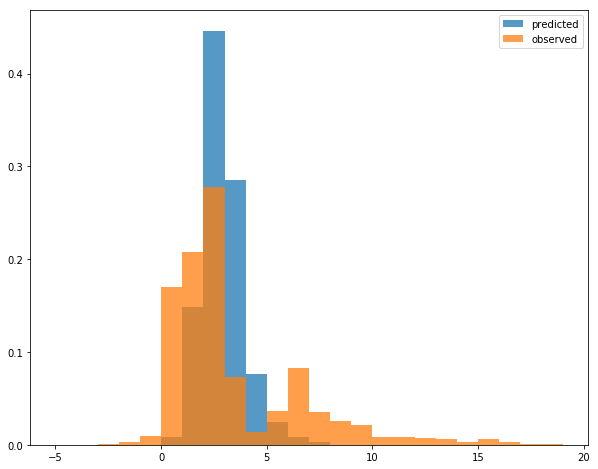

In [24]:
plt.figure(figsize=(10, 8))
plt.hist(pd.Series(lush_ridge_y_pred), bins=range(-5,20), alpha=0.75, density=True, label='predicted')
plt.hist(pd.Series(lush_ridge_y_test), bins=range(-5,20), alpha=0.75, density=True, label='observed')
plt.legend()
plt.show()

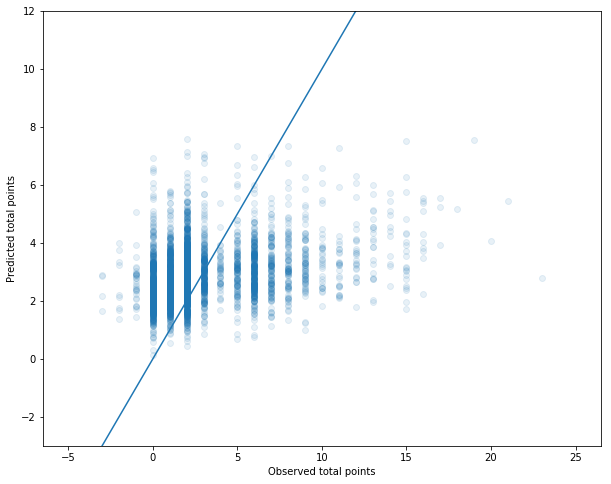

In [25]:
plt.figure(figsize=(10, 8))
plt.scatter(pd.Series(lush_ridge_y_test), pd.Series(lush_ridge_y_pred), alpha=0.1)
plt.plot(np.linspace(-5, 25), np.linspace(-5, 25))
plt.ylabel('Predicted total points')
plt.xlabel('Observed total points')
plt.ylim((-3, 12))
plt.show()

### Ridge regression (stark)

In [26]:
stark_ridge_model = Ridge(alpha=1e-8)

In [27]:
stark_ridge_features = [
    'C(element)[T.40]', 'C(element)[T.43]', 'C(element)[T.49]',
    'C(element)[T.69]', 'C(element)[T.91]', 'C(element)[T.115]',
    'C(element)[T.116]', 'C(element)[T.122]', 'C(element)[T.134]',
    'C(element)[T.172]', 'C(element)[T.221]', 'C(element)[T.234]',
    'C(element)[T.245]', 'C(element)[T.246]', 'C(element)[T.247]',
    'C(element)[T.262]', 'C(element)[T.295]', 'C(element)[T.301]',
    'C(element)[T.306]', 'C(element)[T.333]', 'C(element)[T.356]',
    'C(element)[T.364]', 'C(element)[T.365]', 'C(element)[T.391]',
    'C(element)[T.411]', 'C(element)[T.423]', 'C(element)[T.425]',
    'C(element)[T.437]', 'C(element)[T.462]', 'C(element)[T.465]',
    'C(element)[T.484]', 'C(element_type)[T.2]', 'C(element_type)[T.3]',
    'C(element_type)[T.4]', 'C(opposition_team)[T.9]',
    'C(opposition_team)[T.12]', 'C(opposition_team)[T.13]', 'value'
]

In [28]:
stark_ridge_y_pred, stark_ridge_y_test, stark_ridge_df_test = predict_test_set(
    element_gameweek_df,
    stark_ridge_model,
    features=stark_ridge_features,
    standardise=True
)

In [29]:
stark_ridge_test_loss = (
    mean_absolute_error(stark_ridge_y_test, stark_ridge_y_pred),
    mean_squared_error(stark_ridge_y_test, stark_ridge_y_pred),
    r2_score(stark_ridge_y_test, stark_ridge_y_pred)
)
stark_ridge_test_loss

(2.2825443585935585, 9.594886878178908, 0.06596301113410075)

In [30]:
stark_ridge_df_test.head()

,safe_web_name,element,event,fixture,team,opposition_team,was_home,element_type,value,is_sunday,...,rolling_var_total_points_home,rolling_avg_total_points_against_opposition_ground_element_type,rolling_var_total_points_against_opposition_ground_element_type,total_points,minutes,expected_avg_total_points_against_opposition_team,expected_var_total_points_against_opposition_team,expected_avg_total_points_at_ground,expected_var_total_points_at_ground,predicted_total_points
58,leno,2,21,201,1,9,1,1,48,0,...,3.476190,3.000000,3.000000,3,90,2.478082,3.264527,3.142857,3.476190,4.411503
286,kolasinac,8,21,201,1,9,1,2,49,0,...,9.200000,3.000000,3.000000,7,90,2.415031,11.280897,3.800000,9.200000,3.371314
324,chambers,9,21,201,9,1,0,2,42,0,...,2.982143,1.666667,7.546099,0,0,0.691897,2.296830,0.675738,2.686572,2.003772
400,lichtsteiner,11,21,201,1,9,1,2,45,0,...,0.666667,3.000000,3.000000,0,0,0.603758,0.549070,1.000000,0.666667,3.152354
438,sokratis,12,21,201,1,9,1,2,51,0,...,5.100000,3.000000,3.000000,5,90,1.207515,2.445858,1.500000,5.100000,3.480794


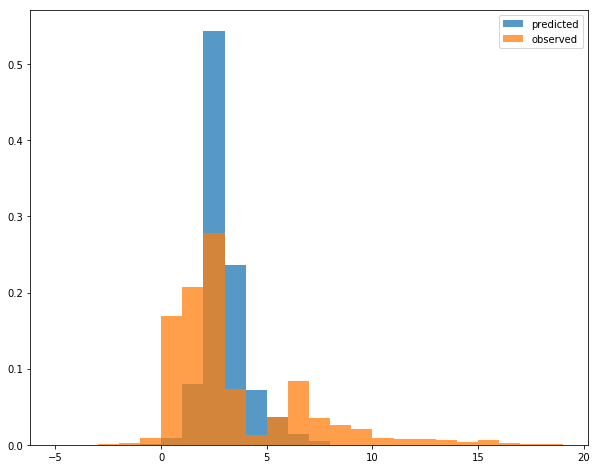

In [31]:
plt.figure(figsize=(10, 8))
plt.hist(pd.Series(stark_ridge_y_pred), bins=range(-5,20), alpha=0.75, density=True, label='predicted')
plt.hist(pd.Series(stark_ridge_y_test), bins=range(-5,20), alpha=0.75, density=True, label='observed')
plt.legend()
plt.show()

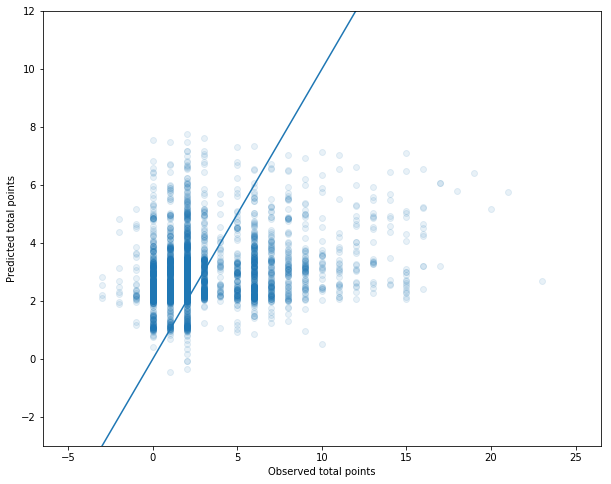

In [32]:
plt.figure(figsize=(10, 8))
plt.scatter(pd.Series(stark_ridge_y_test), pd.Series(stark_ridge_y_pred), alpha=0.1)
plt.plot(np.linspace(-5, 25), np.linspace(-5, 25))
plt.ylabel('Predicted total points')
plt.xlabel('Observed total points')
plt.ylim((-3, 12))
plt.show()

### Lasso regression

In [33]:
lasso_model = Lasso(alpha=1e-8)

In [34]:
lasso_features = ['expected_avg_total_points_at_ground']

In [35]:
lasso_y_pred, lasso_y_test, lasso_df_test = predict_test_set(
    element_gameweek_df,
    lasso_model,
    features=lasso_features,
    standardise=True
)

In [36]:
lasso_test_loss = (
    mean_absolute_error(lasso_y_test, lasso_y_pred),
    mean_squared_error(lasso_y_test, lasso_y_pred),
    r2_score(lasso_y_test, lasso_y_pred)
)
lasso_test_loss

(2.2973044429258143, 9.691293860592644, 0.056578045088887086)

In [37]:
lasso_df_test.head()

,safe_web_name,element,event,fixture,team,opposition_team,was_home,element_type,value,is_sunday,...,rolling_var_total_points_home,rolling_avg_total_points_against_opposition_ground_element_type,rolling_var_total_points_against_opposition_ground_element_type,total_points,minutes,expected_avg_total_points_against_opposition_team,expected_var_total_points_against_opposition_team,expected_avg_total_points_at_ground,expected_var_total_points_at_ground,predicted_total_points
58,leno,2,21,201,1,9,1,1,48,0,...,3.476190,3.000000,3.000000,3,90,2.478082,3.264527,3.142857,3.476190,2.860815
286,kolasinac,8,21,201,1,9,1,2,49,0,...,9.200000,3.000000,3.000000,7,90,2.415031,11.280897,3.800000,9.200000,3.055349
324,chambers,9,21,201,9,1,0,2,42,0,...,2.982143,1.666667,7.546099,0,0,0.691897,2.296830,0.675738,2.686572,2.130473
400,lichtsteiner,11,21,201,1,9,1,2,45,0,...,0.666667,3.000000,3.000000,0,0,0.603758,0.549070,1.000000,0.666667,2.226464
438,sokratis,12,21,201,1,9,1,2,51,0,...,5.100000,3.000000,3.000000,5,90,1.207515,2.445858,1.500000,5.100000,2.374479


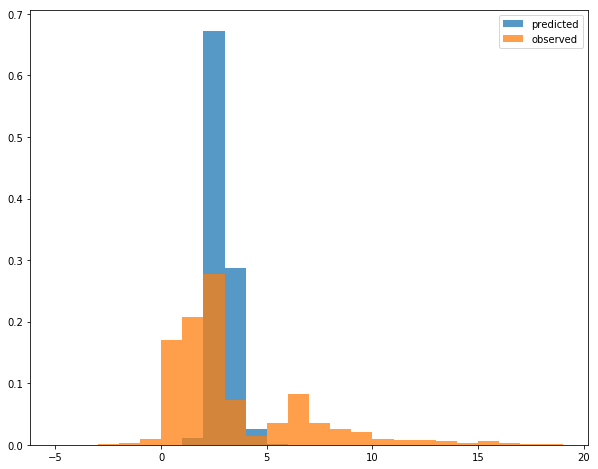

In [38]:
plt.figure(figsize=(10, 8))
plt.hist(pd.Series(lasso_y_pred), bins=range(-5,20), alpha=0.75, density=True, label='predicted')
plt.hist(pd.Series(lasso_y_test), bins=range(-5,20), alpha=0.75, density=True, label='observed')
plt.legend()
plt.show()

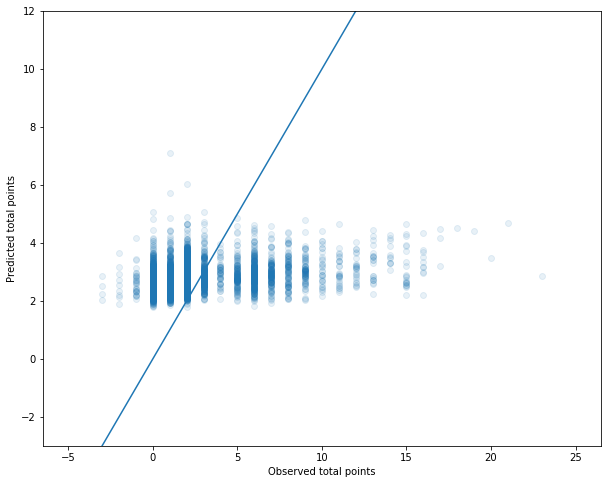

In [39]:
plt.figure(figsize=(10, 8))
plt.scatter(pd.Series(lasso_y_test), pd.Series(lasso_y_pred), alpha=0.1)
plt.plot(np.linspace(-5, 25), np.linspace(-5, 25))
plt.ylabel('Predicted total points')
plt.xlabel('Observed total points')
plt.ylim((-3, 12))
plt.show()

### Radial basis SVM regression

In [40]:
rbf_svr_model = SVR(kernel='rbf', gamma=0.012, C=1.5, epsilon=2.07)

In [41]:
rbf_svr_features = [
    'C(element)[T.4]', 'C(element)[T.6]', 'C(element)[T.8]',
    'C(element)[T.12]', 'C(element)[T.13]', 'C(element)[T.14]',
    'C(element)[T.18]', 'C(element)[T.23]', 'C(element)[T.33]',
    'C(element)[T.37]', 'C(element)[T.39]', 'C(element)[T.40]',
    'C(element)[T.42]', 'C(element)[T.43]', 'C(element)[T.48]',
    'C(element)[T.49]', 'C(element)[T.50]', 'C(element)[T.54]',
    'C(element)[T.55]', 'C(element)[T.56]', 'C(element)[T.57]',
    'C(element)[T.58]', 'C(element)[T.60]', 'C(element)[T.62]',
    'C(element)[T.66]', 'C(element)[T.69]', 'C(element)[T.71]',
    'C(element)[T.72]', 'C(element)[T.73]', 'C(element)[T.75]',
    'C(element)[T.76]', 'C(element)[T.77]', 'C(element)[T.79]',
    'C(element)[T.80]', 'C(element)[T.82]', 'C(element)[T.83]',
    'C(element)[T.84]', 'C(element)[T.85]', 'C(element)[T.88]',
    'C(element)[T.90]', 'C(element)[T.91]', 'C(element)[T.92]',
    'C(element)[T.95]', 'C(element)[T.98]', 'C(element)[T.101]',
    'C(element)[T.105]', 'C(element)[T.110]', 'C(element)[T.113]',
    'C(element)[T.115]', 'C(element)[T.116]', 'C(element)[T.118]',
    'C(element)[T.124]', 'C(element)[T.126]', 'C(element)[T.127]',
    'C(element)[T.134]', 'C(element)[T.137]', 'C(element)[T.140]',
    'C(element)[T.141]', 'C(element)[T.145]', 'C(element)[T.147]',
    'C(element)[T.152]', 'C(element)[T.156]', 'C(element)[T.157]',
    'C(element)[T.160]', 'C(element)[T.164]', 'C(element)[T.167]',
    'C(element)[T.168]', 'C(element)[T.169]', 'C(element)[T.172]',
    'C(element)[T.175]', 'C(element)[T.178]', 'C(element)[T.181]',
    'C(element)[T.183]', 'C(element)[T.184]', 'C(element)[T.189]',
    'C(element)[T.190]', 'C(element)[T.191]', 'C(element)[T.192]',
    'C(element)[T.193]', 'C(element)[T.195]', 'C(element)[T.198]',
    'C(element)[T.199]', 'C(element)[T.200]', 'C(element)[T.202]',
    'C(element)[T.206]', 'C(element)[T.210]', 'C(element)[T.211]',
    'C(element)[T.213]', 'C(element)[T.215]', 'C(element)[T.219]',
    'C(element)[T.221]', 'C(element)[T.225]', 'C(element)[T.226]',
    'C(element)[T.231]', 'C(element)[T.233]', 'C(element)[T.234]',
    'C(element)[T.236]', 'C(element)[T.242]', 'C(element)[T.243]',
    'C(element)[T.245]', 'C(element)[T.246]', 'C(element)[T.247]',
    'C(element)[T.249]', 'C(element)[T.251]', 'C(element)[T.252]',
    'C(element)[T.253]', 'C(element)[T.254]', 'C(element)[T.256]',
    'C(element)[T.257]', 'C(element)[T.258]', 'C(element)[T.260]',
    'C(element)[T.262]', 'C(element)[T.263]', 'C(element)[T.264]',
    'C(element)[T.265]', 'C(element)[T.268]', 'C(element)[T.269]',
    'C(element)[T.270]', 'C(element)[T.271]', 'C(element)[T.272]',
    'C(element)[T.274]', 'C(element)[T.275]', 'C(element)[T.280]',
    'C(element)[T.281]', 'C(element)[T.282]', 'C(element)[T.288]',
    'C(element)[T.289]', 'C(element)[T.291]', 'C(element)[T.294]',
    'C(element)[T.295]', 'C(element)[T.299]', 'C(element)[T.300]',
    'C(element)[T.301]', 'C(element)[T.302]', 'C(element)[T.304]',
    'C(element)[T.305]', 'C(element)[T.306]', 'C(element)[T.309]',
    'C(element)[T.312]', 'C(element)[T.315]', 'C(element)[T.317]',
    'C(element)[T.318]', 'C(element)[T.324]', 'C(element)[T.327]',
    'C(element)[T.328]', 'C(element)[T.331]', 'C(element)[T.332]',
    'C(element)[T.333]', 'C(element)[T.335]', 'C(element)[T.336]',
    'C(element)[T.343]', 'C(element)[T.344]', 'C(element)[T.346]',
    'C(element)[T.352]', 'C(element)[T.353]', 'C(element)[T.355]',
    'C(element)[T.356]', 'C(element)[T.357]', 'C(element)[T.360]',
    'C(element)[T.362]', 'C(element)[T.364]', 'C(element)[T.365]',
    'C(element)[T.368]', 'C(element)[T.369]', 'C(element)[T.370]',
    'C(element)[T.372]', 'C(element)[T.376]', 'C(element)[T.380]',
    'C(element)[T.386]', 'C(element)[T.390]', 'C(element)[T.391]',
    'C(element)[T.393]', 'C(element)[T.394]', 'C(element)[T.395]',
    'C(element)[T.396]', 'C(element)[T.400]', 'C(element)[T.402]',
    'C(element)[T.403]', 'C(element)[T.408]', 'C(element)[T.411]',
    'C(element)[T.415]', 'C(element)[T.417]', 'C(element)[T.419]',
    'C(element)[T.423]', 'C(element)[T.425]', 'C(element)[T.426]',
    'C(element)[T.427]', 'C(element)[T.431]', 'C(element)[T.432]',
    'C(element)[T.433]', 'C(element)[T.437]', 'C(element)[T.447]',
    'C(element)[T.450]', 'C(element)[T.451]', 'C(element)[T.455]',
    'C(element)[T.456]', 'C(element)[T.459]', 'C(element)[T.461]',
    'C(element)[T.462]', 'C(element)[T.465]', 'C(element)[T.467]',
    'C(element)[T.468]', 'C(element)[T.473]', 'C(element)[T.474]',
    'C(element)[T.475]', 'C(element)[T.476]', 'C(element)[T.478]',
    'C(element)[T.479]', 'C(element)[T.480]', 'C(element)[T.482]',
    'C(element)[T.483]', 'C(element)[T.484]', 'C(element)[T.487]',
    'C(element)[T.488]', 'C(element)[T.490]', 'C(element)[T.492]',
    'C(element)[T.493]', 'C(element)[T.499]', 'C(element)[T.503]',
    'C(element)[T.504]', 'C(element)[T.505]', 'C(element)[T.506]',
    'C(element)[T.509]', 'C(element)[T.510]', 'C(element)[T.511]',
    'C(element)[T.512]', 'C(element)[T.513]', 'C(element)[T.516]',
    'C(element)[T.517]', 'C(element)[T.526]', 'C(element)[T.527]',
    'C(element)[T.536]', 'C(element)[T.539]', 'C(element)[T.549]',
    'C(element_type)[T.2]', 'C(element_type)[T.3]', 'C(element_type)[T.4]',
    'C(team)[T.6]', 'C(team)[T.7]', 'C(team)[T.8]', 'C(team)[T.10]',
    'C(team)[T.12]', 'C(team)[T.14]', 'C(team)[T.16]', 'C(team)[T.17]',
    'C(team)[T.20]', 'C(opposition_team)[T.2]', 'C(opposition_team)[T.3]',
    'C(opposition_team)[T.4]', 'C(opposition_team)[T.5]',
    'C(opposition_team)[T.6]', 'C(opposition_team)[T.7]',
    'C(opposition_team)[T.8]', 'C(opposition_team)[T.9]',
    'C(opposition_team)[T.10]', 'C(opposition_team)[T.12]',
    'C(opposition_team)[T.13]', 'C(opposition_team)[T.14]',
    'C(opposition_team)[T.15]', 'C(opposition_team)[T.16]',
    'C(opposition_team)[T.17]', 'C(opposition_team)[T.18]',
    'C(opposition_team)[T.19]', 'C(opposition_team)[T.20]', 'value',
    'is_sunday', 'is_weekday', 'rolling_avg_minutes_element_p3',
    'rolling_avg_bps_element', 'rolling_avg_goals_scored_element',
    'rolling_avg_completed_passes_element', 'rolling_avg_tackled_element',
    'rolling_avg_dribbles_element', 'rolling_avg_offside_element',
    'rolling_avg_total_points_against_opposition_team',
    'expected_avg_total_points_against_opposition_team'
]

In [42]:
rbf_svr_y_pred, rbf_svr_y_test, rbf_svr_df_test = predict_test_set(
    element_gameweek_df,
    rbf_svr_model,
    features=rbf_svr_features,
    standardise=True
)

In [43]:
rbf_svr_test_loss = (
    mean_absolute_error(rbf_svr_y_test, rbf_svr_y_pred),
    mean_squared_error(rbf_svr_y_test, rbf_svr_y_pred),
    r2_score(rbf_svr_y_test, rbf_svr_y_pred)
)
rbf_svr_test_loss

(2.2807040419194884, 9.431990439366304, 0.08182055079426409)

In [44]:
rbf_svr_df_test.head()

,safe_web_name,element,event,fixture,team,opposition_team,was_home,element_type,value,is_sunday,...,rolling_var_total_points_home,rolling_avg_total_points_against_opposition_ground_element_type,rolling_var_total_points_against_opposition_ground_element_type,total_points,minutes,expected_avg_total_points_against_opposition_team,expected_var_total_points_against_opposition_team,expected_avg_total_points_at_ground,expected_var_total_points_at_ground,predicted_total_points
58,leno,2,21,201,1,9,1,1,48,0,...,3.476190,3.000000,3.000000,3,90,2.478082,3.264527,3.142857,3.476190,3.576108
286,kolasinac,8,21,201,1,9,1,2,49,0,...,9.200000,3.000000,3.000000,7,90,2.415031,11.280897,3.800000,9.200000,3.129998
324,chambers,9,21,201,9,1,0,2,42,0,...,2.982143,1.666667,7.546099,0,0,0.691897,2.296830,0.675738,2.686572,2.088314
400,lichtsteiner,11,21,201,1,9,1,2,45,0,...,0.666667,3.000000,3.000000,0,0,0.603758,0.549070,1.000000,0.666667,2.544892
438,sokratis,12,21,201,1,9,1,2,51,0,...,5.100000,3.000000,3.000000,5,90,1.207515,2.445858,1.500000,5.100000,3.052386


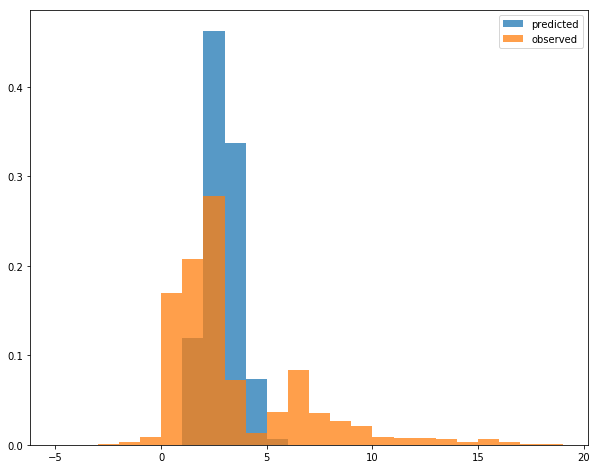

In [45]:
plt.figure(figsize=(10, 8))
plt.hist(pd.Series(rbf_svr_y_pred), bins=range(-5,20), alpha=0.75, density=True, label='predicted')
plt.hist(pd.Series(rbf_svr_y_test), bins=range(-5,20), alpha=0.75, density=True, label='observed')
plt.legend()
plt.show()

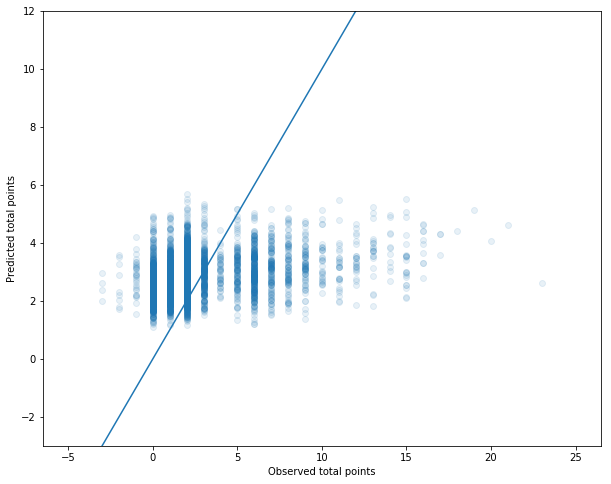

In [46]:
plt.figure(figsize=(10, 8))
plt.scatter(pd.Series(rbf_svr_y_test), pd.Series(rbf_svr_y_pred), alpha=0.1)
plt.plot(np.linspace(-5, 25), np.linspace(-5, 25))
plt.ylabel('Predicted total points')
plt.xlabel('Observed total points')
plt.ylim((-3, 12))
plt.show()

### Linear SVM regression

In [47]:
linear_svr_model = SVR(kernel='linear', C=0.29, epsilon=2.16)

In [48]:
linear_svr_features = [
    'C(element)[T.4]', 'C(element)[T.6]', 'C(element)[T.8]',
    'C(element)[T.12]', 'C(element)[T.13]', 'C(element)[T.14]',
    'C(element)[T.18]', 'C(element)[T.23]', 'C(element)[T.33]',
    'C(element)[T.37]', 'C(element)[T.39]', 'C(element)[T.40]',
    'C(element)[T.42]', 'C(element)[T.43]', 'C(element)[T.48]',
    'C(element)[T.49]', 'C(element)[T.50]', 'C(element)[T.54]',
    'C(element)[T.55]', 'C(element)[T.56]', 'C(element)[T.57]',
    'C(element)[T.58]', 'C(element)[T.60]', 'C(element)[T.62]',
    'C(element)[T.66]', 'C(element)[T.69]', 'C(element)[T.71]',
    'C(element)[T.72]', 'C(element)[T.73]', 'C(element)[T.75]',
    'C(element)[T.76]', 'C(element)[T.77]', 'C(element)[T.79]',
    'C(element)[T.80]', 'C(element)[T.82]', 'C(element)[T.83]',
    'C(element)[T.84]', 'C(element)[T.85]', 'C(element)[T.88]',
    'C(element)[T.90]', 'C(element)[T.91]', 'C(element)[T.92]',
    'C(element)[T.95]', 'C(element)[T.98]', 'C(element)[T.101]',
    'C(element)[T.105]', 'C(element)[T.110]', 'C(element)[T.113]',
    'C(element)[T.115]', 'C(element)[T.116]', 'C(element)[T.118]',
    'C(element)[T.124]', 'C(element)[T.126]', 'C(element)[T.127]',
    'C(element)[T.134]', 'C(element)[T.137]', 'C(element)[T.140]',
    'C(element)[T.141]', 'C(element)[T.145]', 'C(element)[T.147]',
    'C(element)[T.152]', 'C(element)[T.156]', 'C(element)[T.157]',
    'C(element)[T.160]', 'C(element)[T.164]', 'C(element)[T.167]',
    'C(element)[T.168]', 'C(element)[T.169]', 'C(element)[T.172]',
    'C(element)[T.175]', 'C(element)[T.178]', 'C(element)[T.181]',
    'C(element)[T.183]', 'C(element)[T.184]', 'C(element)[T.189]',
    'C(element)[T.190]', 'C(element)[T.191]', 'C(element)[T.192]',
    'C(element)[T.193]', 'C(element)[T.195]', 'C(element)[T.198]',
    'C(element)[T.199]', 'C(element)[T.200]', 'C(element)[T.202]',
    'C(element)[T.206]', 'C(element)[T.210]', 'C(element)[T.211]',
    'C(element)[T.213]', 'C(element)[T.215]', 'C(element)[T.219]',
    'C(element)[T.221]', 'C(element)[T.225]', 'C(element)[T.226]',
    'C(element)[T.231]', 'C(element)[T.233]', 'C(element)[T.234]',
    'C(element)[T.236]', 'C(element)[T.242]', 'C(element)[T.243]',
    'C(element)[T.245]', 'C(element)[T.246]', 'C(element)[T.247]',
    'C(element)[T.249]', 'C(element)[T.251]', 'C(element)[T.252]',
    'C(element)[T.253]', 'C(element)[T.254]', 'C(element)[T.256]',
    'C(element)[T.257]', 'C(element)[T.258]', 'C(element)[T.260]',
    'C(element)[T.262]', 'C(element)[T.263]', 'C(element)[T.264]',
    'C(element)[T.265]', 'C(element)[T.268]', 'C(element)[T.269]',
    'C(element)[T.270]', 'C(element)[T.271]', 'C(element)[T.272]',
    'C(element)[T.274]', 'C(element)[T.275]', 'C(element)[T.280]',
    'C(element)[T.281]', 'C(element)[T.282]', 'C(element)[T.288]',
    'C(element)[T.289]', 'C(element)[T.291]', 'C(element)[T.294]',
    'C(element)[T.295]', 'C(element)[T.299]', 'C(element)[T.300]',
    'C(element)[T.301]', 'C(element)[T.302]', 'C(element)[T.304]',
    'C(element)[T.305]', 'C(element)[T.306]', 'C(element)[T.309]',
    'C(element)[T.312]', 'C(element)[T.315]', 'C(element)[T.317]',
    'C(element)[T.318]', 'C(element)[T.324]', 'C(element)[T.327]',
    'C(element)[T.328]', 'C(element)[T.331]', 'C(element)[T.332]',
    'C(element)[T.333]', 'C(element)[T.335]', 'C(element)[T.336]',
    'C(element)[T.343]', 'C(element)[T.344]', 'C(element)[T.346]',
    'C(element)[T.352]', 'C(element)[T.353]', 'C(element)[T.355]',
    'C(element)[T.356]', 'C(element)[T.357]', 'C(element)[T.360]',
    'C(element)[T.362]', 'C(element)[T.364]', 'C(element)[T.365]',
    'C(element)[T.368]', 'C(element)[T.369]', 'C(element)[T.370]',
    'C(element)[T.372]', 'C(element)[T.376]', 'C(element)[T.380]',
    'C(element)[T.386]', 'C(element)[T.390]', 'C(element)[T.391]',
    'C(element)[T.393]', 'C(element)[T.394]', 'C(element)[T.395]',
    'C(element)[T.396]', 'C(element)[T.400]', 'C(element)[T.402]',
    'C(element)[T.403]', 'C(element)[T.408]', 'C(element)[T.411]',
    'C(element)[T.415]', 'C(element)[T.417]', 'C(element)[T.419]',
    'C(element)[T.423]', 'C(element)[T.425]', 'C(element)[T.426]',
    'C(element)[T.427]', 'C(element)[T.431]', 'C(element)[T.432]',
    'C(element)[T.433]', 'C(element)[T.437]', 'C(element)[T.447]',
    'C(element)[T.450]', 'C(element)[T.451]', 'C(element)[T.455]',
    'C(element)[T.456]', 'C(element)[T.459]', 'C(element)[T.461]',
    'C(element)[T.462]', 'C(element)[T.465]', 'C(element)[T.467]',
    'C(element)[T.468]', 'C(element)[T.473]', 'C(element)[T.474]',
    'C(element)[T.475]', 'C(element)[T.476]', 'C(element)[T.478]',
    'C(element)[T.479]', 'C(element)[T.480]', 'C(element)[T.482]',
    'C(element)[T.483]', 'C(element)[T.484]', 'C(element)[T.487]',
    'C(element)[T.488]', 'C(element)[T.490]', 'C(element)[T.492]',
    'C(element)[T.493]', 'C(element)[T.499]', 'C(element)[T.503]',
    'C(element)[T.504]', 'C(element)[T.505]', 'C(element)[T.506]',
    'C(element)[T.509]', 'C(element)[T.510]', 'C(element)[T.511]',
    'C(element)[T.512]', 'C(element)[T.513]', 'C(element)[T.516]',
    'C(element)[T.517]', 'C(element)[T.526]', 'C(element)[T.527]',
    'C(element)[T.536]', 'C(element)[T.539]', 'C(element)[T.549]',
    'C(element_type)[T.2]', 'C(element_type)[T.3]', 'C(element_type)[T.4]',
    'C(team)[T.6]', 'C(team)[T.7]', 'C(team)[T.8]', 'C(team)[T.10]',
    'C(team)[T.12]', 'C(team)[T.14]', 'C(team)[T.16]', 'C(team)[T.17]',
    'C(team)[T.20]', 'C(opposition_team)[T.2]', 'C(opposition_team)[T.3]',
    'C(opposition_team)[T.4]', 'C(opposition_team)[T.5]',
    'C(opposition_team)[T.6]', 'C(opposition_team)[T.7]',
    'C(opposition_team)[T.8]', 'C(opposition_team)[T.9]',
    'C(opposition_team)[T.10]', 'C(opposition_team)[T.12]',
    'C(opposition_team)[T.13]', 'C(opposition_team)[T.14]',
    'C(opposition_team)[T.15]', 'C(opposition_team)[T.16]',
    'C(opposition_team)[T.17]', 'C(opposition_team)[T.18]',
    'C(opposition_team)[T.19]', 'C(opposition_team)[T.20]', 'value',
    'is_sunday', 'is_weekday', 'rolling_avg_minutes_element_p3',
    'rolling_avg_bps_element', 'rolling_avg_goals_scored_element',
    'rolling_avg_completed_passes_element', 'rolling_avg_tackled_element',
    'rolling_avg_dribbles_element', 'rolling_avg_offside_element',
    'rolling_avg_total_points_against_opposition_team',
    'expected_avg_total_points_against_opposition_team'
]

In [49]:
linear_svr_y_pred, linear_svr_y_test, linear_svr_df_test = predict_test_set(
    element_gameweek_df,
    linear_svr_model,
    features=linear_svr_features,
    standardise=True
)

In [50]:
linear_svr_test_loss = (
    mean_absolute_error(linear_svr_y_test, linear_svr_y_pred),
    mean_squared_error(linear_svr_y_test, linear_svr_y_pred),
    r2_score(linear_svr_y_test, linear_svr_y_pred)
)
linear_svr_test_loss

(2.3153025196965364, 9.458455594839448, 0.07924423755140331)

In [51]:
linear_svr_df_test.head()

,safe_web_name,element,event,fixture,team,opposition_team,was_home,element_type,value,is_sunday,...,rolling_var_total_points_home,rolling_avg_total_points_against_opposition_ground_element_type,rolling_var_total_points_against_opposition_ground_element_type,total_points,minutes,expected_avg_total_points_against_opposition_team,expected_var_total_points_against_opposition_team,expected_avg_total_points_at_ground,expected_var_total_points_at_ground,predicted_total_points
58,leno,2,21,201,1,9,1,1,48,0,...,3.476190,3.000000,3.000000,3,90,2.478082,3.264527,3.142857,3.476190,3.867706
286,kolasinac,8,21,201,1,9,1,2,49,0,...,9.200000,3.000000,3.000000,7,90,2.415031,11.280897,3.800000,9.200000,3.504317
324,chambers,9,21,201,9,1,0,2,42,0,...,2.982143,1.666667,7.546099,0,0,0.691897,2.296830,0.675738,2.686572,2.305437
400,lichtsteiner,11,21,201,1,9,1,2,45,0,...,0.666667,3.000000,3.000000,0,0,0.603758,0.549070,1.000000,0.666667,2.921196
438,sokratis,12,21,201,1,9,1,2,51,0,...,5.100000,3.000000,3.000000,5,90,1.207515,2.445858,1.500000,5.100000,2.873282


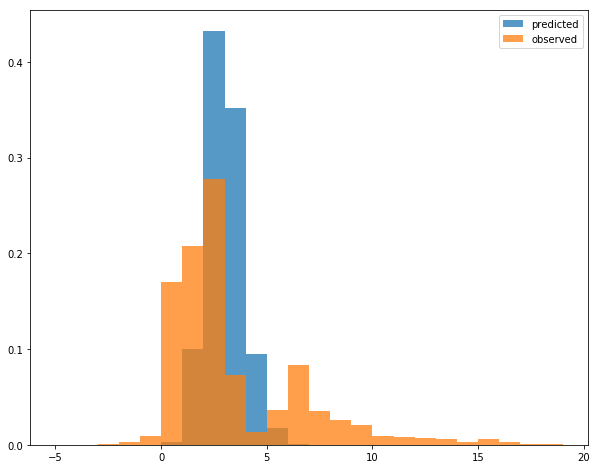

In [52]:
plt.figure(figsize=(10, 8))
plt.hist(pd.Series(linear_svr_y_pred), bins=range(-5,20), alpha=0.75, density=True, label='predicted')
plt.hist(pd.Series(linear_svr_y_test), bins=range(-5,20), alpha=0.75, density=True, label='observed')
plt.legend()
plt.show()

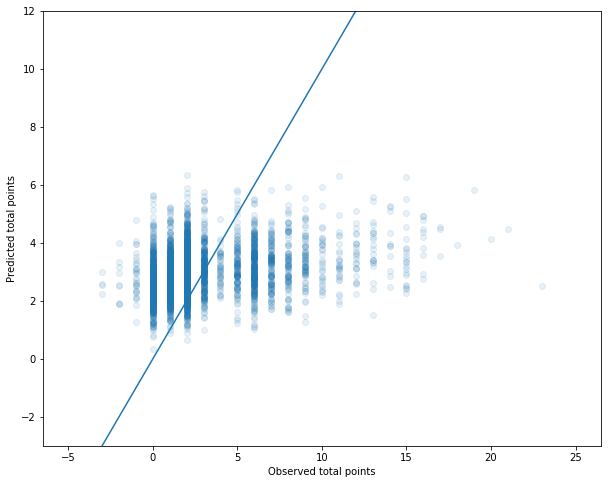

In [53]:
plt.figure(figsize=(10, 8))
plt.scatter(pd.Series(linear_svr_y_test), pd.Series(linear_svr_y_pred), alpha=0.1)
plt.plot(np.linspace(-5, 25), np.linspace(-5, 25))
plt.ylabel('Predicted total points')
plt.xlabel('Observed total points')
plt.ylim((-3, 12))
plt.show()

### Decision tree (lush)

In [113]:
lush_tree_model = DecisionTreeRegressor(random_state=0, min_samples_leaf=0.065, max_features=0.45)

In [114]:
lush_tree_y_pred, lush_tree_y_test, lush_tree_df_test = predict_test_set(
    element_gameweek_df,
    lush_tree_model,
    standardise=False
)

In [115]:
lush_tree_test_loss = (
    mean_absolute_error(lush_tree_y_test, lush_tree_y_pred),
    mean_squared_error(lush_tree_y_test, lush_tree_y_pred),
    r2_score(lush_tree_y_test, lush_tree_y_pred)
)
lush_tree_test_loss

(2.0440485849020043, 8.314565096686975, 0.1905989674249292)

In [77]:
lush_tree_df_test.head()

,safe_web_name,element,event,fixture,team,opposition_team,was_home,element_type,value,is_sunday,...,rolling_var_total_points_home,rolling_avg_total_points_against_opposition_ground_element_type,rolling_var_total_points_against_opposition_ground_element_type,total_points,minutes,expected_avg_total_points_against_opposition_team,expected_var_total_points_against_opposition_team,expected_avg_total_points_at_ground,expected_var_total_points_at_ground,predicted_total_points
58,leno,2,21,201,1,9,1,1,48,0,...,3.476190,3.000000,3.000000,3,90,2.478082,3.264527,3.142857,3.476190,3.012658
286,kolasinac,8,21,201,1,9,1,2,49,0,...,9.200000,3.000000,3.000000,7,90,2.415031,11.280897,3.800000,9.200000,3.492958
324,chambers,9,21,201,9,1,0,2,42,0,...,2.982143,1.666667,7.546099,0,0,0.691897,2.296830,0.675738,2.686572,0.406650
400,lichtsteiner,11,21,201,1,9,1,2,45,0,...,0.666667,3.000000,3.000000,0,0,0.603758,0.549070,1.000000,0.666667,0.406650
438,sokratis,12,21,201,1,9,1,2,51,0,...,5.100000,3.000000,3.000000,5,90,1.207515,2.445858,1.500000,5.100000,3.492958


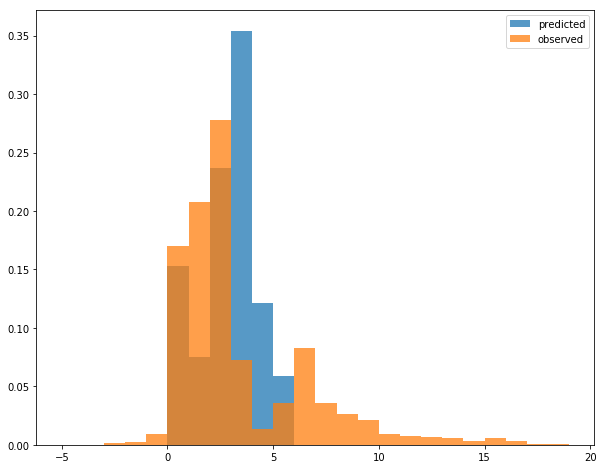

In [78]:
plt.figure(figsize=(10, 8))
plt.hist(pd.Series(lush_tree_y_pred), bins=range(-5,20), alpha=0.75, density=True, label='predicted')
plt.hist(pd.Series(lush_tree_y_test), bins=range(-5,20), alpha=0.75, density=True, label='observed')
plt.legend()
plt.show()

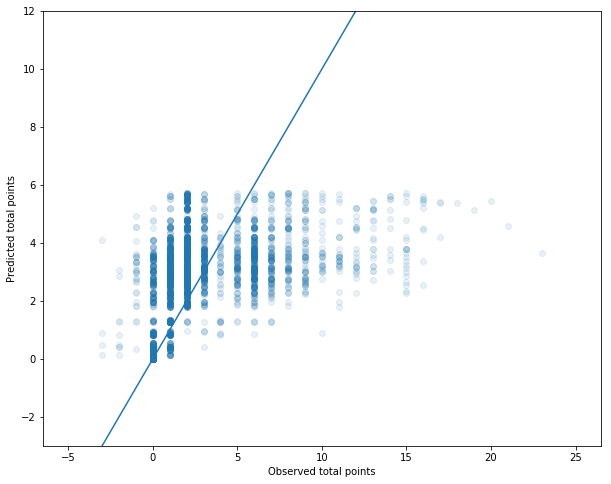

In [79]:
plt.figure(figsize=(10, 8))
plt.scatter(pd.Series(lush_tree_y_test), pd.Series(lush_tree_y_pred), alpha=0.1)
plt.plot(np.linspace(-5, 25), np.linspace(-5, 25))
plt.ylabel('Predicted total points')
plt.xlabel('Observed total points')
plt.ylim((-3, 12))
plt.show()

### Decision tree (stark)

In [92]:
stark_tree_model = DecisionTreeRegressor(random_state=0, min_samples_leaf=0.027)

In [93]:
stark_tree_features = ['value', 'expected_avg_total_points_against_opposition_team']

In [94]:
stark_tree_y_pred, stark_tree_y_test, stark_tree_df_test = predict_test_set(
    element_gameweek_df,
    stark_tree_model,
    standardise=False
)

In [95]:
stark_tree_test_loss = (
    mean_absolute_error(stark_tree_y_test, stark_tree_y_pred),
    mean_squared_error(stark_tree_y_test, stark_tree_y_pred),
    r2_score(stark_tree_y_test, stark_tree_y_pred)
)
stark_tree_test_loss

(1.9837246304008165, 8.192880204117534, 0.20244467150555945)

In [96]:
stark_tree_df_test.head()

,safe_web_name,element,event,fixture,team,opposition_team,was_home,element_type,value,is_sunday,...,rolling_var_total_points_home,rolling_avg_total_points_against_opposition_ground_element_type,rolling_var_total_points_against_opposition_ground_element_type,total_points,minutes,expected_avg_total_points_against_opposition_team,expected_var_total_points_against_opposition_team,expected_avg_total_points_at_ground,expected_var_total_points_at_ground,predicted_total_points
58,leno,2,21,201,1,9,1,1,48,0,...,3.476190,3.000000,3.000000,3,90,2.478082,3.264527,3.142857,3.476190,4.661017
286,kolasinac,8,21,201,1,9,1,2,49,0,...,9.200000,3.000000,3.000000,7,90,2.415031,11.280897,3.800000,9.200000,4.661017
324,chambers,9,21,201,9,1,0,2,42,0,...,2.982143,1.666667,7.546099,0,0,0.691897,2.296830,0.675738,2.686572,0.000000
400,lichtsteiner,11,21,201,1,9,1,2,45,0,...,0.666667,3.000000,3.000000,0,0,0.603758,0.549070,1.000000,0.666667,0.000000
438,sokratis,12,21,201,1,9,1,2,51,0,...,5.100000,3.000000,3.000000,5,90,1.207515,2.445858,1.500000,5.100000,4.661017


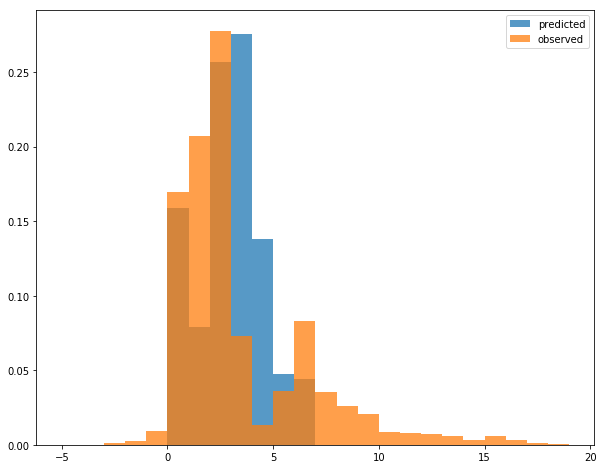

In [97]:
plt.figure(figsize=(10, 8))
plt.hist(pd.Series(stark_tree_y_pred), bins=range(-5,20), alpha=0.75, density=True, label='predicted')
plt.hist(pd.Series(stark_tree_y_test), bins=range(-5,20), alpha=0.75, density=True, label='observed')
plt.legend()
plt.show()

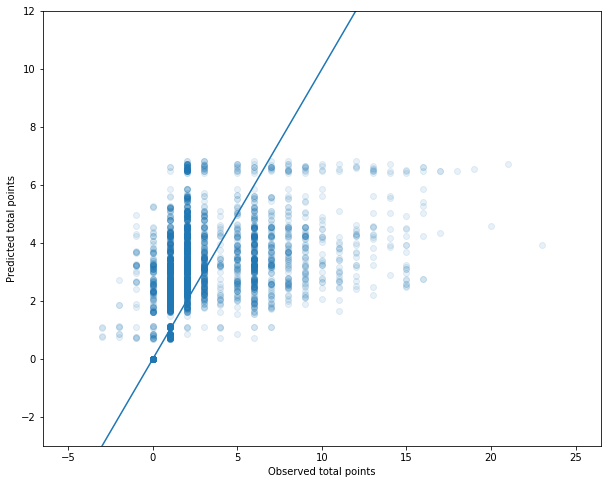

In [98]:
plt.figure(figsize=(10, 8))
plt.scatter(pd.Series(stark_tree_y_test), pd.Series(stark_tree_y_pred), alpha=0.1)
plt.plot(np.linspace(-5, 25), np.linspace(-5, 25))
plt.ylabel('Predicted total points')
plt.xlabel('Observed total points')
plt.ylim((-3, 12))
plt.show()

### Random forest (lush)

In [129]:
lush_forest_model = RandomForestRegressor(n_estimators=120,
                                          min_samples_leaf=0.015,
                                          max_features=0.84,
                                          random_state=0)

In [130]:
lush_forest_y_pred, lush_forest_y_test, lush_forest_df_test = predict_test_set(
    element_gameweek_df,
    lush_forest_model,
    standardise=False
)

In [131]:
lush_forest_test_loss = (
    mean_absolute_error(lush_forest_y_test, lush_forest_y_pred),
    mean_squared_error(lush_forest_y_test, lush_forest_y_pred),
    r2_score(lush_forest_y_test, lush_forest_y_pred)
)
lush_forest_test_loss

(1.9547625616406417, 7.906712673807179, 0.2303023275379782)

In [132]:
lush_forest_df_test.head()

,safe_web_name,element,event,fixture,team,opposition_team,was_home,element_type,value,is_sunday,...,rolling_var_total_points_home,rolling_avg_total_points_against_opposition_ground_element_type,rolling_var_total_points_against_opposition_ground_element_type,total_points,minutes,expected_avg_total_points_against_opposition_team,expected_var_total_points_against_opposition_team,expected_avg_total_points_at_ground,expected_var_total_points_at_ground,predicted_total_points
58,leno,2,21,201,1,9,1,1,48,0,...,3.476190,3.000000,3.000000,3,90,2.478082,3.264527,3.142857,3.476190,4.049185
286,kolasinac,8,21,201,1,9,1,2,49,0,...,9.200000,3.000000,3.000000,7,90,2.415031,11.280897,3.800000,9.200000,3.962112
324,chambers,9,21,201,9,1,0,2,42,0,...,2.982143,1.666667,7.546099,0,0,0.691897,2.296830,0.675738,2.686572,0.013684
400,lichtsteiner,11,21,201,1,9,1,2,45,0,...,0.666667,3.000000,3.000000,0,0,0.603758,0.549070,1.000000,0.666667,0.011490
438,sokratis,12,21,201,1,9,1,2,51,0,...,5.100000,3.000000,3.000000,5,90,1.207515,2.445858,1.500000,5.100000,3.596815


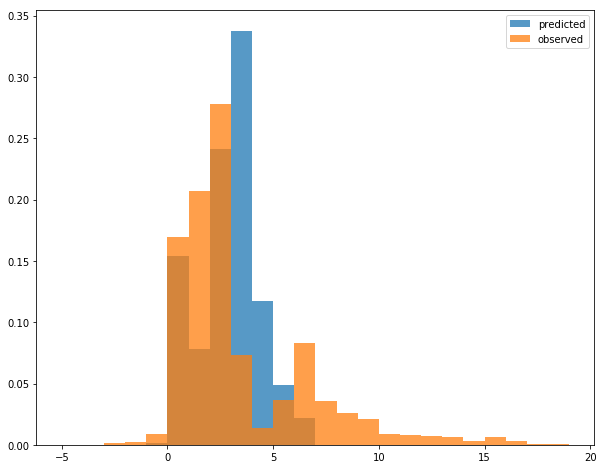

In [133]:
plt.figure(figsize=(10, 8))
plt.hist(pd.Series(lush_forest_y_pred), bins=range(-5,20), alpha=0.75, density=True, label='predicted')
plt.hist(pd.Series(lush_forest_y_test), bins=range(-5,20), alpha=0.75, density=True, label='observed')
plt.legend()
plt.show()

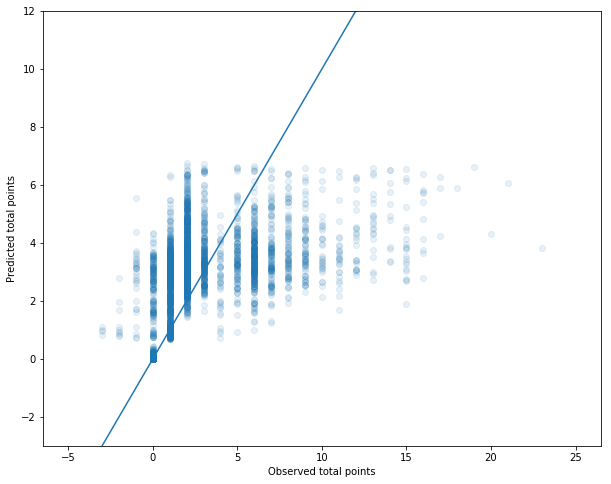

In [134]:
plt.figure(figsize=(10, 8))
plt.scatter(pd.Series(lush_forest_y_test), pd.Series(lush_forest_y_pred), alpha=0.1)
plt.plot(np.linspace(-5, 25), np.linspace(-5, 25))
plt.ylabel('Predicted total points')
plt.xlabel('Observed total points')
plt.ylim((-3, 12))
plt.show()

### Random forest (stark)

In [141]:
stark_forest_model = RandomForestRegressor(n_estimators=120,
                                           min_samples_leaf=0.0135,
                                           max_features=0.73,
                                           random_state=0)

In [142]:
stark_tree_features = [
    'value', 'is_late', 'rolling_avg_total_points_element',
    'rolling_var_total_points_element', 'rolling_avg_minutes_element_p3',
    'rolling_avg_bps_element', 'rolling_avg_bonus_element',
    'rolling_avg_goals_scored_element', 'rolling_avg_minutes_element',
    'rolling_avg_clean_sheets_element', 'rolling_avg_completed_passes_element',
    'rolling_avg_recoveries_element', 'rolling_avg_key_passes_element',
    'rolling_avg_tackled_element', 'rolling_avg_dribbles_element',
    'rolling_avg_clearances_blocks_interceptions_element',
    'rolling_avg_target_missed_element', 'rolling_avg_fouls_element',
    'rolling_avg_tackles_element', 'rolling_avg_big_chances_missed_element',
    'rolling_avg_goals_conceded_element',
    'rolling_avg_total_points_element_type',
    'rolling_avg_total_points_own_team',
    'rolling_avg_total_points_opposition_team',
    'rolling_avg_total_points_against_opposition_team',
    'rolling_avg_total_points_against_opposition_team_element_type',
    'expected_avg_total_points_against_opposition_team',
    'expected_avg_total_points_at_ground'
]

In [143]:
stark_forest_y_pred, stark_forest_y_test, stark_forest_df_test = predict_test_set(
    element_gameweek_df,
    stark_forest_model,
    standardise=False
)

In [144]:
stark_forest_test_loss = (
    mean_absolute_error(stark_forest_y_test, stark_forest_y_pred),
    mean_squared_error(stark_forest_y_test, stark_forest_y_pred),
    r2_score(stark_forest_y_test, stark_forest_y_pred)
)
stark_forest_test_loss

(1.9588059074869963, 7.912689280069145, 0.22972052064567805)

In [145]:
stark_forest_df_test.head()

,safe_web_name,element,event,fixture,team,opposition_team,was_home,element_type,value,is_sunday,...,rolling_var_total_points_home,rolling_avg_total_points_against_opposition_ground_element_type,rolling_var_total_points_against_opposition_ground_element_type,total_points,minutes,expected_avg_total_points_against_opposition_team,expected_var_total_points_against_opposition_team,expected_avg_total_points_at_ground,expected_var_total_points_at_ground,predicted_total_points
58,leno,2,21,201,1,9,1,1,48,0,...,3.476190,3.000000,3.000000,3,90,2.478082,3.264527,3.142857,3.476190,3.920282
286,kolasinac,8,21,201,1,9,1,2,49,0,...,9.200000,3.000000,3.000000,7,90,2.415031,11.280897,3.800000,9.200000,3.973618
324,chambers,9,21,201,9,1,0,2,42,0,...,2.982143,1.666667,7.546099,0,0,0.691897,2.296830,0.675738,2.686572,0.020285
400,lichtsteiner,11,21,201,1,9,1,2,45,0,...,0.666667,3.000000,3.000000,0,0,0.603758,0.549070,1.000000,0.666667,0.022109
438,sokratis,12,21,201,1,9,1,2,51,0,...,5.100000,3.000000,3.000000,5,90,1.207515,2.445858,1.500000,5.100000,3.586148


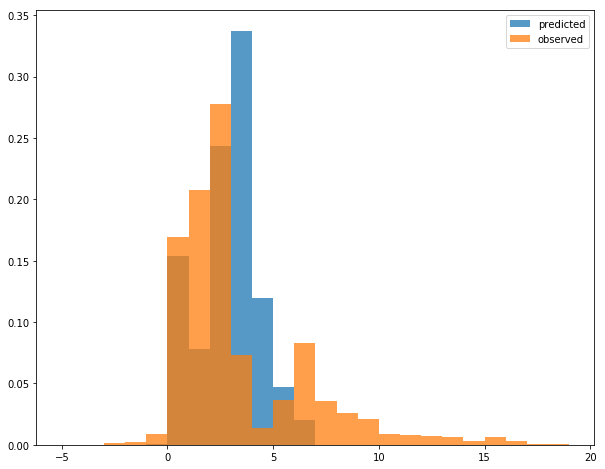

In [146]:
plt.figure(figsize=(10, 8))
plt.hist(pd.Series(stark_forest_y_pred), bins=range(-5,20), alpha=0.75, density=True, label='predicted')
plt.hist(pd.Series(stark_forest_y_test), bins=range(-5,20), alpha=0.75, density=True, label='observed')
plt.legend()
plt.show()

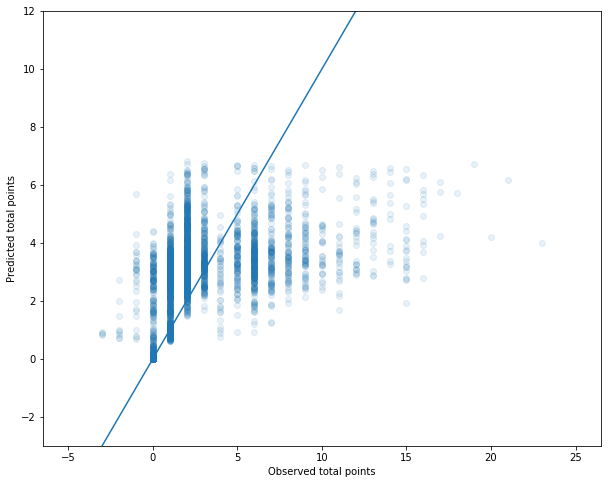

In [147]:
plt.figure(figsize=(10, 8))
plt.scatter(pd.Series(stark_forest_y_test), pd.Series(stark_forest_y_pred), alpha=0.1)
plt.plot(np.linspace(-5, 25), np.linspace(-5, 25))
plt.ylabel('Predicted total points')
plt.xlabel('Observed total points')
plt.ylim((-3, 12))
plt.show()

### Gradient boosted trees (lush)

In [154]:
lush_boost_model = GradientBoostingRegressor(n_estimators=120,
                                             max_features=0.61,
                                             min_samples_leaf=0.015,
                                             learning_rate=0.035,
                                             criterion='mse',
                                             random_state=0)

In [155]:
lush_boost_y_pred, lush_boost_y_test, lush_boost_df_test = predict_test_set(
    element_gameweek_df,
    lush_boost_model,
    standardise=False
)

In [156]:
lush_boost_test_loss = (
    mean_absolute_error(lush_boost_y_test, lush_boost_y_pred),
    mean_squared_error(lush_boost_y_test, lush_boost_y_pred),
    r2_score(lush_boost_y_test, lush_boost_y_pred)
)
lush_boost_test_loss

(1.9732599759336062, 7.863188939696783, 0.23453924852191688)

In [157]:
lush_boost_df_test.head()

,safe_web_name,element,event,fixture,team,opposition_team,was_home,element_type,value,is_sunday,...,rolling_var_total_points_home,rolling_avg_total_points_against_opposition_ground_element_type,rolling_var_total_points_against_opposition_ground_element_type,total_points,minutes,expected_avg_total_points_against_opposition_team,expected_var_total_points_against_opposition_team,expected_avg_total_points_at_ground,expected_var_total_points_at_ground,predicted_total_points
58,leno,2,21,201,1,9,1,1,48,0,...,3.476190,3.000000,3.000000,3,90,2.478082,3.264527,3.142857,3.476190,3.531812
286,kolasinac,8,21,201,1,9,1,2,49,0,...,9.200000,3.000000,3.000000,7,90,2.415031,11.280897,3.800000,9.200000,3.727395
324,chambers,9,21,201,9,1,0,2,42,0,...,2.982143,1.666667,7.546099,0,0,0.691897,2.296830,0.675738,2.686572,0.052574
400,lichtsteiner,11,21,201,1,9,1,2,45,0,...,0.666667,3.000000,3.000000,0,0,0.603758,0.549070,1.000000,0.666667,0.369557
438,sokratis,12,21,201,1,9,1,2,51,0,...,5.100000,3.000000,3.000000,5,90,1.207515,2.445858,1.500000,5.100000,3.478013


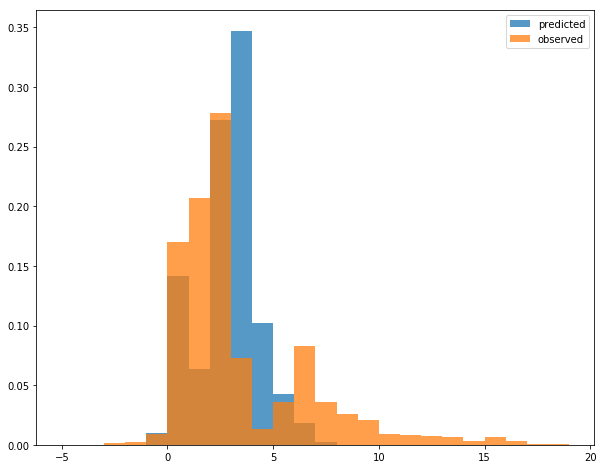

In [158]:
plt.figure(figsize=(10, 8))
plt.hist(pd.Series(lush_boost_y_pred), bins=range(-5,20), alpha=0.75, density=True, label='predicted')
plt.hist(pd.Series(lush_boost_y_test), bins=range(-5,20), alpha=0.75, density=True, label='observed')
plt.legend()
plt.show()

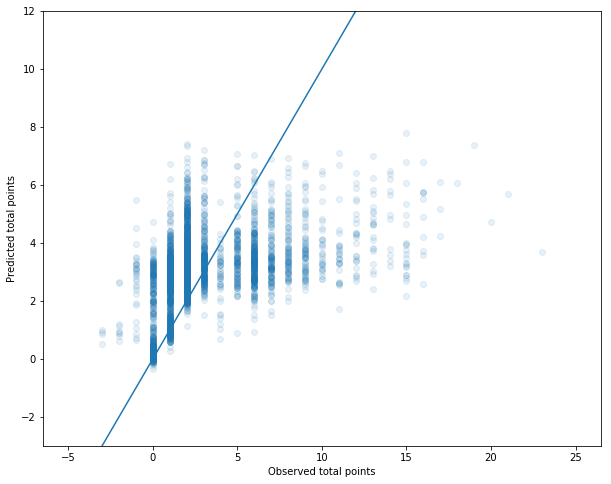

In [159]:
plt.figure(figsize=(10, 8))
plt.scatter(pd.Series(lush_boost_y_test), pd.Series(lush_boost_y_pred), alpha=0.1)
plt.plot(np.linspace(-5, 25), np.linspace(-5, 25))
plt.ylabel('Predicted total points')
plt.xlabel('Observed total points')
plt.ylim((-3, 12))
plt.show()

### Gradient boosted trees (stark)

In [163]:
stark_boost_model = GradientBoostingRegressor(n_estimators=120,
                                              max_features=0.8,
                                              min_samples_leaf=0.02,
                                              learning_rate=0.05,
                                              criterion='mse',
                                              random_state=0)

In [164]:
stark_tree_features = [
    'value', 'rolling_avg_minutes_element_p3', 'rolling_avg_minutes_element',
    'rolling_avg_key_passes_element',
    'rolling_avg_clearances_blocks_interceptions_element',
    'rolling_avg_big_chances_missed_element',
    'rolling_avg_total_points_own_team',
    'rolling_avg_total_points_opposition_team',
    'rolling_avg_total_points_against_opposition_team',
    'rolling_avg_total_points_against_opposition_team_element_type',
    'expected_avg_total_points_against_opposition_team',
    'expected_avg_total_points_at_ground'
]

In [165]:
stark_boost_y_pred, stark_boost_y_test, stark_boost_df_test = predict_test_set(
    element_gameweek_df,
    stark_boost_model,
    standardise=False
)

In [166]:
stark_boost_test_loss = (
    mean_absolute_error(stark_boost_y_test, stark_boost_y_pred),
    mean_squared_error(stark_boost_y_test, stark_boost_y_pred),
    r2_score(stark_boost_y_test, stark_boost_y_pred)
)
stark_boost_test_loss

(1.971063777092578, 7.83509186380843, 0.237274424922837)

In [167]:
stark_boost_df_test.head()

,safe_web_name,element,event,fixture,team,opposition_team,was_home,element_type,value,is_sunday,...,rolling_var_total_points_home,rolling_avg_total_points_against_opposition_ground_element_type,rolling_var_total_points_against_opposition_ground_element_type,total_points,minutes,expected_avg_total_points_against_opposition_team,expected_var_total_points_against_opposition_team,expected_avg_total_points_at_ground,expected_var_total_points_at_ground,predicted_total_points
58,leno,2,21,201,1,9,1,1,48,0,...,3.476190,3.000000,3.000000,3,90,2.478082,3.264527,3.142857,3.476190,3.640099
286,kolasinac,8,21,201,1,9,1,2,49,0,...,9.200000,3.000000,3.000000,7,90,2.415031,11.280897,3.800000,9.200000,3.826037
324,chambers,9,21,201,9,1,0,2,42,0,...,2.982143,1.666667,7.546099,0,0,0.691897,2.296830,0.675738,2.686572,0.034703
400,lichtsteiner,11,21,201,1,9,1,2,45,0,...,0.666667,3.000000,3.000000,0,0,0.603758,0.549070,1.000000,0.666667,0.280375
438,sokratis,12,21,201,1,9,1,2,51,0,...,5.100000,3.000000,3.000000,5,90,1.207515,2.445858,1.500000,5.100000,3.638819


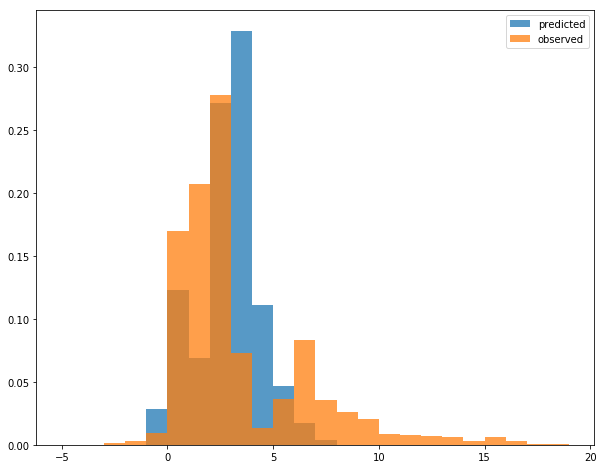

In [168]:
plt.figure(figsize=(10, 8))
plt.hist(pd.Series(stark_boost_y_pred), bins=range(-5,20), alpha=0.75, density=True, label='predicted')
plt.hist(pd.Series(stark_boost_y_test), bins=range(-5,20), alpha=0.75, density=True, label='observed')
plt.legend()
plt.show()

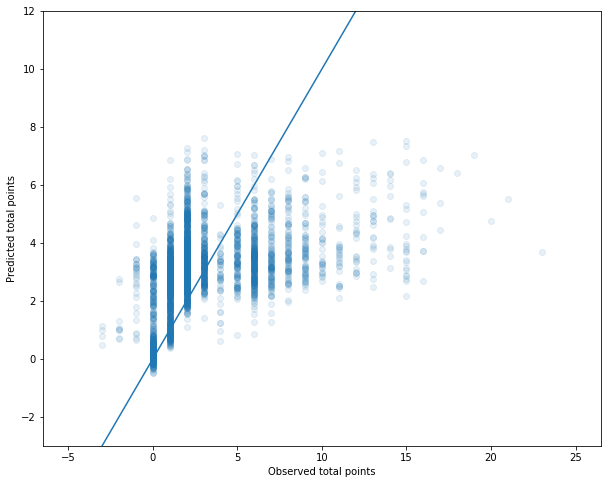

In [169]:
plt.figure(figsize=(10, 8))
plt.scatter(pd.Series(stark_boost_y_test), pd.Series(stark_boost_y_pred), alpha=0.1)
plt.plot(np.linspace(-5, 25), np.linspace(-5, 25))
plt.ylabel('Predicted total points')
plt.xlabel('Observed total points')
plt.ylim((-3, 12))
plt.show()

## Constructing teams

### Linear regression

In [54]:
(
    lr_first_team_arr,
    lr_bench_arr,
    lr_total_points_arr,
    lr_predicted_total_points_arr,
    lr_team_df_arr
) = \
construct_event_teams_from_scratch(lr_df_test, verbose=1)

predicting event 21
predicting event 22
predicting event 23
predicting event 24
predicting event 25
predicting event 26
predicting event 27
predicting event 28
predicting event 29
predicting event 30
predicting event 31
predicting event 32
32 'NoneType' object is not iterable
predicting event 33
predicting event 34
34 'NoneType' object is not iterable
predicting event 35
predicting event 36
predicting event 37
predicting event 38


In [83]:
lr_teams_total_points = sum(lr_total_points_arr)
lr_teams_total_points

651

### Ridge regression (lush)

In [56]:
(
    lush_ridge_first_team_arr,
    lush_ridge_bench_arr,
    lush_ridge_total_points_arr,
    lush_ridge_predicted_total_points_arr,
    lush_ridge_team_df_arr
) = \
construct_event_teams_from_scratch(lush_ridge_df_test, verbose=1)

predicting event 21
predicting event 22
predicting event 23
predicting event 24
predicting event 25
predicting event 26
predicting event 27
predicting event 28
predicting event 29
predicting event 30
predicting event 31
predicting event 32
predicting event 33
predicting event 34
predicting event 35
predicting event 36
predicting event 37
predicting event 38


In [84]:
lush_ridge_teams_total_points = sum(lush_ridge_total_points_arr)
lush_ridge_teams_total_points

1200

### Ridge regression (stark)

In [59]:
(
    stark_ridge_first_team_arr,
    stark_ridge_bench_arr,
    stark_ridge_total_points_arr,
    stark_ridge_predicted_total_points_arr,
    stark_ridge_team_df_arr
) = \
construct_event_teams_from_scratch(stark_ridge_df_test, verbose=1)

predicting event 21
predicting event 22
predicting event 23
predicting event 24
predicting event 25
predicting event 26
predicting event 27
predicting event 28
predicting event 29
predicting event 30
predicting event 31
predicting event 32
predicting event 33
predicting event 34
predicting event 35
predicting event 36
predicting event 37
predicting event 38


In [86]:
stark_ridge_teams_total_points = sum(stark_ridge_total_points_arr)
stark_ridge_teams_total_points

1035

### Lasso regression

In [61]:
(
    lasso_first_team_arr,
    lasso_bench_arr,
    lasso_total_points_arr,
    lasso_predicted_total_points_arr,
    lasso_team_df_arr
) = \
construct_event_teams_from_scratch(lasso_df_test, verbose=1)

predicting event 21
predicting event 22
predicting event 23
predicting event 24
predicting event 25
predicting event 26
predicting event 27
predicting event 28
predicting event 29
predicting event 30
predicting event 31
predicting event 32
predicting event 33
predicting event 34
predicting event 35
predicting event 36
predicting event 37
predicting event 38


In [87]:
lasso_teams_total_points = sum(lasso_total_points_arr)
lasso_teams_total_points

1163

### Radial basis SVM regression

In [63]:
(
    rbf_svr_first_team_arr,
    rbf_svr_bench_arr,
    rbf_svr_total_points_arr,
    rbf_svr_predicted_total_points_arr,
    rbf_svr_team_df_arr
) = \
construct_event_teams_from_scratch(rbf_svr_df_test, verbose=1)

predicting event 21
predicting event 22
predicting event 23
predicting event 24
predicting event 25
predicting event 26
predicting event 27
predicting event 28
predicting event 29
predicting event 30
predicting event 31
predicting event 32
predicting event 33
predicting event 34
predicting event 35
predicting event 36
predicting event 37
predicting event 38


In [88]:
rbf_svr_teams_total_points = sum(rbf_svr_total_points_arr)
rbf_svr_teams_total_points

1158

### Linear basis SVM regression

In [65]:
(
    linear_svr_first_team_arr,
    linear_svr_bench_arr,
    linear_svr_total_points_arr,
    linear_svr_predicted_total_points_arr,
    linear_svr_team_df_arr
) = \
construct_event_teams_from_scratch(linear_svr_df_test, verbose=1)

predicting event 21
predicting event 22
predicting event 23
predicting event 24
predicting event 25
predicting event 26
predicting event 27
predicting event 28
predicting event 29
predicting event 30
predicting event 31
predicting event 32
predicting event 33
predicting event 34
predicting event 35
predicting event 36
predicting event 37
predicting event 38


In [89]:
linear_svr_teams_total_points = sum(linear_svr_total_points_arr)
linear_svr_teams_total_points

1171

### Decision tree (lush)

In [81]:
(
    lush_tree_first_team_arr,
    lush_tree_bench_arr,
    lush_tree_total_points_arr,
    lush_tree_predicted_total_points_arr,
    lush_tree_team_df_arr
) = \
construct_event_teams_from_scratch(lush_tree_df_test, verbose=1)

predicting event 21
predicting event 22
predicting event 23
predicting event 24
predicting event 25
predicting event 26
predicting event 27
predicting event 28
predicting event 29
predicting event 30
predicting event 31
predicting event 32
predicting event 33
predicting event 34
predicting event 35
predicting event 36
predicting event 37
predicting event 38


In [128]:
lush_tree_teams_total_points = sum(lush_tree_total_points_arr)
lush_tree_teams_total_points

1187

### Decision tree (stark)

In [99]:
(
    stark_tree_first_team_arr,
    stark_tree_bench_arr,
    stark_tree_total_points_arr,
    stark_tree_predicted_total_points_arr,
    stark_tree_team_df_arr
) = \
construct_event_teams_from_scratch(stark_tree_df_test, verbose=1)

predicting event 21
predicting event 22
predicting event 23
predicting event 24
predicting event 25
predicting event 26
predicting event 27
predicting event 28
predicting event 29
predicting event 30
predicting event 31
predicting event 32
predicting event 33
predicting event 34
predicting event 35
predicting event 36
predicting event 37
predicting event 38


In [152]:
stark_tree_teams_total_points = sum(stark_tree_total_points_arr)
stark_tree_teams_total_points

1232

### Random forest (lush)

In [136]:
(
    lush_forest_first_team_arr,
    lush_forest_bench_arr,
    lush_forest_total_points_arr,
    lush_forest_predicted_total_points_arr,
    lush_forest_team_df_arr
) = \
construct_event_teams_from_scratch(lush_forest_df_test, verbose=1)

predicting event 21
predicting event 22
predicting event 23
predicting event 24
predicting event 25
predicting event 26
predicting event 27
predicting event 28
predicting event 29
predicting event 30
predicting event 31
predicting event 32
predicting event 33
predicting event 34
predicting event 35
predicting event 36
predicting event 37
predicting event 38


In [137]:
lush_forest_teams_total_points = sum(lush_forest_total_points_arr)
lush_forest_teams_total_points

1316

### Random forest (stark)

In [148]:
(
    stark_forest_first_team_arr,
    stark_forest_bench_arr,
    stark_forest_total_points_arr,
    stark_forest_predicted_total_points_arr,
    stark_forest_team_df_arr
) = \
construct_event_teams_from_scratch(stark_forest_df_test, verbose=1)

predicting event 21
predicting event 22
predicting event 23
predicting event 24
predicting event 25
predicting event 26
predicting event 27
predicting event 28
predicting event 29
predicting event 30
predicting event 31
predicting event 32
predicting event 33
predicting event 34
predicting event 35
predicting event 36
predicting event 37
predicting event 38


In [149]:
stark_forest_teams_total_points = sum(stark_forest_total_points_arr)
stark_forest_teams_total_points

1299

### Gradient boosted trees (lush)

In [171]:
(
    lush_boost_first_team_arr,
    lush_boost_bench_arr,
    lush_boost_total_points_arr,
    lush_boost_predicted_total_points_arr,
    lush_boost_team_df_arr
) = \
construct_event_teams_from_scratch(lush_boost_df_test, verbose=1)

predicting event 21
predicting event 22
predicting event 23
predicting event 24
predicting event 25
predicting event 26
predicting event 27
predicting event 28
predicting event 29
predicting event 30
predicting event 31
predicting event 32
predicting event 33
predicting event 34
predicting event 35
predicting event 36
predicting event 37
predicting event 38


In [172]:
lush_boost_teams_total_points = sum(lush_boost_total_points_arr)
lush_boost_teams_total_points

1330

### Gradient boosted trees (stark)

In [173]:
(
    stark_boost_first_team_arr,
    stark_boost_bench_arr,
    stark_boost_total_points_arr,
    stark_boost_predicted_total_points_arr,
    stark_boost_team_df_arr
) = \
construct_event_teams_from_scratch(stark_boost_df_test, verbose=1)

predicting event 21
predicting event 22
predicting event 23
predicting event 24
predicting event 25
predicting event 26
predicting event 27
predicting event 28
predicting event 29
predicting event 30
predicting event 31
predicting event 32
predicting event 33
predicting event 34
predicting event 35
predicting event 36
predicting event 37
predicting event 38


In [174]:
stark_boost_teams_total_points = sum(stark_boost_total_points_arr)
stark_boost_teams_total_points

1305

## Summary

In [170]:
pd.DataFrame([
    ('Linear regression', lr_test_loss[0], lr_test_loss[1], lr_test_loss[2]),
    ('Ridge regression (lush)', lush_ridge_test_loss[0], lush_ridge_test_loss[1], lush_ridge_test_loss[2]),
    ('Ridge regression (stark)', stark_ridge_test_loss[0], stark_ridge_test_loss[1], stark_ridge_test_loss[2]),
    ('Lasso regression', lasso_test_loss[0], lasso_test_loss[1], lasso_test_loss[2]),
    ('Radius basis SVM regression', rbf_svr_test_loss[0], rbf_svr_test_loss[1], rbf_svr_test_loss[2]),
    ('Linear basis SVM regression', linear_svr_test_loss[0], linear_svr_test_loss[1], linear_svr_test_loss[2]),
    ('Decision tree (lush)', lush_tree_test_loss[0], lush_tree_test_loss[1], lush_tree_test_loss[2]),
    ('Decision tree (stark)', stark_tree_test_loss[0], stark_tree_test_loss[1], stark_tree_test_loss[2]),
    ('Random forest (lush)', lush_forest_test_loss[0], lush_forest_test_loss[1], lush_forest_test_loss[2]),
    ('Random forest (stark)', stark_forest_test_loss[0], stark_forest_test_loss[1], stark_forest_test_loss[2]),
    ('Gradient boosted trees (lush)', lush_boost_test_loss[0], lush_boost_test_loss[1], lush_boost_test_loss[2]),
    ('Gradient boosted trees (stark)', stark_boost_test_loss[0], stark_boost_test_loss[1], stark_boost_test_loss[2]), 
], columns=['model', 'MAE', 'MSE', 'r2'])

,model,MAE,MSE,r2
0,Linear regression,2.389162,10.275135,-0.000257
1,Ridge regression (lush),2.259268,9.308154,0.093876
2,Ridge regression (stark),2.282544,9.594887,0.065963
3,Lasso regression,2.297304,9.691294,0.056578
4,Radius basis SVM regression,2.280704,9.431990,0.081821
5,Linear basis SVM regression,2.315303,9.458456,0.079244
6,Decision tree (lush),2.044049,8.314565,0.190599
7,Decision tree (stark),1.983725,8.192880,0.202445
8,Random forest (lush),1.954763,7.906713,0.230302
9,Random forest (stark),1.958806,7.912689,0.229721


In [175]:
pd.DataFrame([
    ('Linear regression', lr_teams_total_points),
    ('Ridge regression (lush)', lush_ridge_teams_total_points),
    ('Ridge regression (stark)', stark_ridge_teams_total_points),
    ('Lasso regression', lasso_teams_total_points),
    ('Radius basis SVM regression', linear_svr_teams_total_points),
    ('Linear basis SVM regression', rbf_svr_teams_total_points),
    ('Decision tree (lush)', lush_tree_teams_total_points),
    ('Decision tree (stark)', stark_tree_teams_total_points),
    ('Random forest (lush)', lush_forest_teams_total_points),
    ('Random forest (stark)', stark_forest_teams_total_points),
    ('Gradient boosted trees (lush)', lush_boost_teams_total_points),
    ('Gradient boosted trees (stark)', stark_boost_teams_total_points),
], columns=['model', 'teams total points'])

,model,teams total points
0,Linear regression,651
1,Ridge regression (lush),1200
2,Ridge regression (stark),1035
3,Lasso regression,1163
4,Radius basis SVM regression,1171
5,Linear basis SVM regression,1158
6,Decision tree (lush),1187
7,Decision tree (stark),1232
8,Random forest (lush),1316
9,Random forest (stark),1299
